In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os
import pandas as pd
import matplotlib.patheffects as pe
import numpy as np
import time
import sys

# Importing the main code.
module_path = os.path.abspath(os.path.join('../src/ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ocloc import ProcessingParameters, ClockDrift, trim_correlation_trace

# OCloC Python Package - Implementation

In order to detect and correct timing errors using ambient noise seismic inteferometry, we developed an algorithm that follows the processing sheme shown in figure . The functional workflow comprises five main processing steps: Interferometric response retrieval, data filtering, time-symmetry shift measurement, time-symmetry verification, construction of the linear system of equations, and results refinement and verification. 



## Step 1: Loading the interferometric responses

Given that Github has a limited capacity to upload data, please request the dataset to David Naranjo (d.f.naranjohernandez@tudelft.nl).
Then, change the path2datadir variable to the location of this folder in your computer.

In [2]:
# Parameters for locating the files where the correlation files and station 
# information is contained.
path2data_dir = "/Users/localadmin/Dropbox/GitHub/data"
path2data_dir = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/correlations_O20"
station_file = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/station_info"

# The reference time is zero time to which the dates of the correlations
# will be compared. It can be the date of deployment. 
reference_time = '2014-08-21T00:00:00.000000Z'

Then we proceed to load this information to the ClockDrift object. The ClockDrift object stores all the information of the different cross-correlations, station metadata and parameters used for processing the data. 
If there are no cross-correlations available for a given station, the program will let you know.

In [3]:
params = ProcessingParameters(
                 freqmin = 0.2, # Low freq. for the bandpass filter
                 freqmax = 0.4, # High freq. for the bandpass filter 
                 ref_vel = 4500, # m/s
                 dist_trh = 2.5, # Minimum station separation in terms of wavelength
                 snr_trh = 30, # Signal-to-noise ratio threshold
                 noise_st = 240, # start of the noise window.
                 dt_err = 0.004, # Sampling interval needs to be multiple of this value.
                 resp_details = False)

cd = ClockDrift(station_file, path2data_dir, 
                  reference_time = '2014-08-21T00:00:00.000000Z',
                  list_of_processing_parameters=[params])

No correlation file found for station:O26


Now let's just take as an example the cross-correlations between HAH and O20

In [4]:
station1 = cd.get_station("HAH")
station2 = cd.get_station("O20")

It is possible to check all the information of the stations as:

In [5]:
station2


 Station object
 Code: O20
 Index: 13
 Project: IMAGE
 Sensor type: PZ_OBS
 Needs correction: True
 Latitude: 63.68719
 Longitude: -23.31253
 Elevation: -109.0
 a values: []
 b values: []

Now let's plot the location of both stations to get an overview. For this you will need to have Basemap installed on your computer.

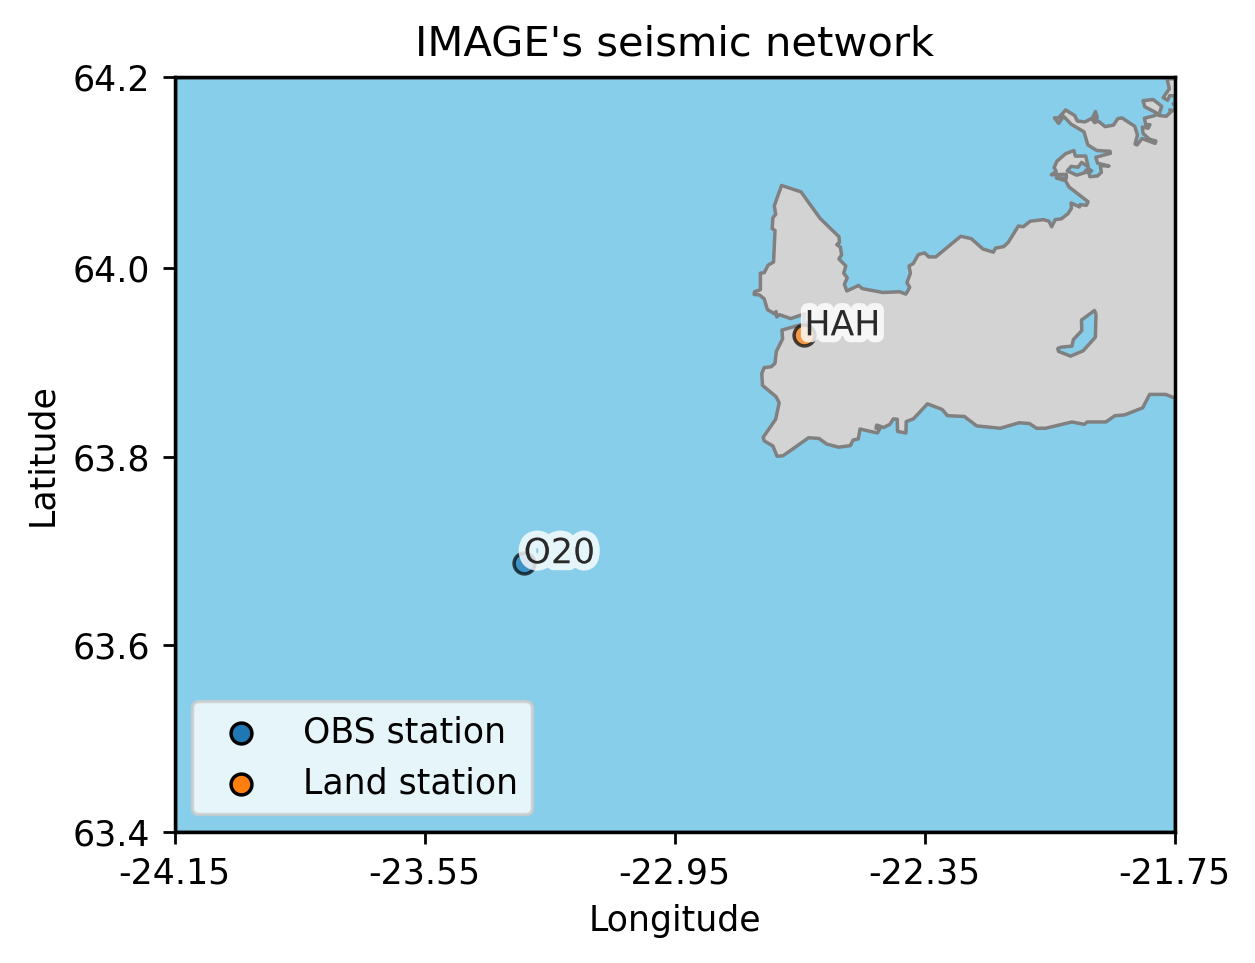

In [6]:
# Create the figure using Basemap.
fig = plt.figure(dpi=250)
llcrnrlon = -24.15
urcrnrlon = -21.75
llcrnrlat = 63.4
urcrnrlat = 64.2
map = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
              urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
              epsg=3857, resolution='h')
for station in [station1, station2]:
    plt.annotate(station.code, map(station.longitude, station.latitude),
                 zorder=9999, alpha=0.8, path_effects=[pe.withStroke(linewidth=4,
                 foreground="white")])
    
    x, y = map(station.longitude, station.latitude)
    # Add a color depending wether the staton needs corection or not
    # In these data-set file the column "needs correction" is True for OBS, so 
    # we use this attribute to select the color.
    color = 'C0' if station.needs_correction else 'C1'
    map.scatter(x, y, c=color, zorder=999,
                edgecolor='k', alpha=0.7)

# We add the legend.
map.scatter([],[], label='OBS station', color='C0', edgecolor='k')
map.scatter([],[], label='Land station', color='C1', edgecolor='k')
plt.legend(loc=3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("IMAGE's seismic network")

# Add the labels
n_ticks = 5

x, y = map(np.linspace(llcrnrlon, urcrnrlon, n_ticks),
           np.linspace(llcrnrlat, urcrnrlat, n_ticks)
           )
plt.xticks(x, np.linspace(llcrnrlon, urcrnrlon, n_ticks))
plt.yticks(y, np.linspace(llcrnrlat, urcrnrlat, n_ticks))
map.drawmapboundary(fill_color='skyblue')
map.fillcontinents(color='lightgray')
map.drawcoastlines(color='grey')
plt.show()

# Checking cross-correlations for a given station pair
We can check the individual cross-correlations of the station pair using the function`get_correlations_of_stationpair()`. This function returns a list of all correlations for a given station pair.

In [7]:
correlations = cd.get_correlations_of_stationpair(station1.code,
                                                 station2.code)
print(correlations[0])


 Correlation object
 Station 1: HAH
 Station 2: O20
 Average date of CC: 2014-10-17T11:50:32.000000Z
 Number of days: 100.0
 Path: /Users/localadmin/Dropbox/GitHub/ocloc/tutorials/correlations_O20/HAH_O20_1413546632_100.sac
 apriori_dt1: Not calculated yet.
 apriori_dt2: Not calculated yet.
 dt_ins_station1: Not calculated yet.
 dt_ins_station2: Not calculated yet.
 t_app: Not calculated yet.



The `Correlation` objects contain all the metadata of the cross-correlation files.
If you want to check the different attributes you just need to do type a `Correlation.` and the attribute you want to access. For example to check the path to the seismic trace you can do:

In [8]:
correlation1 = correlations[0]
print("Path to the directory of correlation is ")
print(correlation1.path2data_dir)

Path to the directory of correlation is 


AttributeError: 'Correlation' object has no attribute 'path2data_dir'


There are several ways to load th actual seismic trace which are:

1. Loading it directly using the path to the correlation file as:

We can get an overview of the cross-correlations of the station pair as follows:

In [ ]:
cd.plot_correlations_of_stationpair(station1.code, station2.code,
                                    min_t=-50, max_t=30)

In [ ]:
correlation
ocloc.read_correlation_file()

If we zoom in we can actually see how the interferometric responses are being shifted over time.

In [ ]:
correlations = cd.get_correlations_of_stationpair(station1_code, 
                                                  station2_code)
tr = ocloc.recorrelations[0]

min_t=-40
max_t=40
freqmin=0.15
freqmax=0.3

# Trim the signal to use only the part we are interested at.
t1, data = trim_correlation_trace(tr, min_t, max_t, freqmin, freqmax)

# index of matching element
acausal_indixes = [idx for idx, val in enumerate(t1) if val > -22 and val < -10]
causal_indixes = [idx for idx, val in enumerate(t1) if val > 12 and val < 25]

#fig, (ax1) = plt.subplots(1, 1, figsize=(5,3), dpi=300)
fig =plt.figure(dpi=300)
ax1 = fig.add_subplot(122)
ax1.plot(t1, data, label=str(tr.stats.average_date)[:10])
ax1.plot(t1[acausal_indixes], data[acausal_indixes], 
         label="Acausal wave", marker="+", color="C3")
ax1.plot(t1[causal_indixes], data[causal_indixes], 
         label="Causal wave", marker=".", color="C3")

ax1.set_title(tr.stats.station_pair)
ax1.set_ylabel('Amplitudes')
ax1.legend(loc=2)
plt.tight_layout()


plt.show()

In [ ]:
correlations
correlations = correlations.normalize()
min_t=-30
max_t=0
freqmin=0.15
freqmax=0.3

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 2), dpi=200)
for tr in correlations:
    # Trim the signal to use only the part we are interested at.
    t1, data = trim_correlation_trace(tr, min_t, max_t, freqmin, freqmax)

    # index of matching element
    acausal_indixes = [idx for idx, val in enumerate(t1) if val > -22 and val < -10]
    causal_indixes = [idx for idx, val in enumerate(t1) if val > 12 and val < 25]
    ax1.plot(t1, data, label=str(tr.stats.average_date)[:10])


# Adding an arrow to graph starting 
# from the base (2, 4) and with the 
# length of 2 units from both x and y
# And setting the width of arrow for
# better visualization
plt.arrow(-18, 0.8, 4, 0, width = 0.1)

ax1.set_title(tr.stats.station_pair)
ax1.set_ylabel('Amplitudes')
ax1.legend(loc=2)
plt.tight_layout()

In [ ]:
cd.calculate_aprioridt_4_allcorrelations()

In [ ]:
station1_code, station2_code = "O01", "KEF"
for sta in cd.stations:
    if sta.needs_correction:
        cd.plot_correlation_beforeNafter_correction(sta.code, station2_code)

In [ ]:
cd.calculate_dt_ins()
cd.calculate_tapp_4_allcorrelations()
cd.build_matrices()
cd.solve_eq()
cd.plot_observed_vs_predicted()
cd.plot_matrix_diff_observed_predicted()
cd.remove_outiers(max_error=1.)
cd.calculate_dt_ins()
cd.plot_matrix_diff_observed_predicted()
cd.build_matrices()
cd.solve_eq()

In [ ]:
cd.plot_observed_vs_predicted()

In [ ]:
cd.plot_matrix_diff_observed_predicted()

# Convergence
We can run several inversions until the a and b valuesstop changing.

In [ ]:
for i in range(4):
    cd.calculate_tapp_4_allcorrelations()
    cd.calculate_dt_ins()
    cd.remove_outiers(max_error=1.)
    cd.calculate_dt_ins()
    cd.build_matrices()
    cd.solve_eq()

In [ ]:
cd.plot_fluctuation_of_a_and_b()

In [ ]:
cd.plot_observed_vs_predicted()

In [ ]:
station2_code = "KEF"
for sta in cd.stations:
    if sta.needs_correction:
        cd.plot_correlation_beforeNafter_correction(sta.code, station2_code)

In [ ]:
cd.plot_obs_and_pred_shifts_with_land_stations("O10")
cd.plot_obs_and_pred_shifts_with_land_stations("O17")

In [ ]:
cd.plot_hist_no_correlations_per_station()

# Results

Having the a (clock drift rate) and b (incurred timing error at t=0) values it is possible to calculate if there is a time shift while the OBS is sinking. For calculating it is necessary to have the initial dates when the OBS started recording.

In [ ]:
import pandas as pd
import obspy
import numpy as np
skew_values_file = "skew_values.csv"
path2file_skew = os.path.join(module_path, skew_values_file)
skew_df = pd.read_csv(path2file_skew, delimiter=",", header=0)
display(skew_df)

In [ ]:
cd.solution

In [ ]:
sensor_codes = skew_df["Sensor code"]
starttimes = skew_df["Start time"]
endtimes = skew_df["End time"]
ref_time = cd.reference_time
skew_measurements = skew_df["skew seconds"]


initial_shift = []
final_shift = []
corrected_stations = []
included_skews = []
clock_drift_per_day = []
for station, starttime, endtime, skew in zip(sensor_codes, starttimes,
                                       endtimes, skew_measurements):
    if station in cd.station_names:
        a = float(cd.solution["a ("+ station + ")"])
        b = float(cd.solution["b ("+ station + ")"])
        dt_start = (obspy.UTCDateTime(starttime) - ref_time)/86400
        dt_ins_start = a*(dt_start) + b
        initial_shift.append(dt_ins_start)
        
        try:
            dt_end = (obspy.UTCDateTime(endtime) - ref_time)/86400
            dt_ins_end = a*(dt_end) + b
        except:
            dt_ins_end = "Recovery time not provided"
        final_shift.append(dt_ins_end)
        corrected_stations.append(station)
        included_skews.append(skew)
        clock_drift_per_day.append(a)

In [ ]:
final_results = pd.DataFrame(list(zip(corrected_stations, initial_shift, 
                                      final_shift, included_skews, clock_drift_per_day)),
                             columns = ["Sensor code", "Incurred timing error at t=0 [s]",
                                       "Timing error at the time of recovery [s]",
                                        "Skew [s]", 
                                        "Clock drift [s/day]"])
display(final_results)

In [ ]:
print(final_results.to_latex(index=False))

In [ ]:
cd.stations[0]

In [ ]:
print(cd.solution.to_latex(index=False))